In [1]:
using Plots, Measures, HDF5

include("../src/LoadData.jl")
include("../src/Support.jl")

# Load data
Y = loadData("NZCOVID_1APR2024");

# Calculate aggregated cases
Y.WeeklyCases = repeat([NaN], length(Y.Ct))
for ii = 1:length(Y.Ct)
    if ii % 7 == 0
        Y.WeeklyCases[ii] = sum(Y.Ct[ii-6:ii])
    end
end

# Load saved files
Xagg = h5read("temp/temporallyAggregatedResults.h5", "X")
θagg = h5read("temp/temporallyAggregatedResults.h5", "theta")

Xdow = h5read("temp/dayofweekResults.h5", "X")
θdow = h5read("temp/dayofweekResults.h5", "theta")

Xnai = h5read("temp/naiveResults.h5", "X")
θnai = h5read("temp/naiveResults.h5", "theta")

# Process results
(mR_agg, medR_agg, lR_agg, uR_agg) = processResults(Xagg[:,:,1])
(mI_agg, medI_agg, lI_agg, uI_agg) = processResults(Xagg[:,:,2])
(mC_agg, medC_agg, lC_agg, uC_agg) = processResults(Xagg[:,:,3])

(mR_dow, medR_dow, lR_dow, uR_dow) = processResults(Xdow[:,:,1])
(mI_dow, medI_dow, lI_dow, uI_dow) = processResults(Xdow[:,:,2])
(mC_dow, medC_dow, lC_dow, uC_dow) = processResults(Xdow[:,:,3])

(mR_nai, medR_nai, lR_nai, uR_nai) = processResults(Xnai[:,:,1])
(mI_nai, medI_nai, lI_nai, uI_nai) = processResults(Xnai[:,:,2])
(mC_nai, medC_nai, lC_nai, uC_nai) = processResults(Xnai[:,:,3])


([0.0, 534.609217, 525.30803, 502.137874, 478.279108, 456.511354, 436.658423, 419.14171, 403.515661, 389.447611  …  336.342717, 354.215298, 374.531217, 404.692166, 434.692121, 622.3958, 778.316835, 1486.97706, 3744.73456, 8473.617452], [0.0, 520.0, 511.0, 489.0, 466.0, 444.0, 425.0, 408.0, 392.0, 379.0  …  221.0, 216.0, 211.0, 207.0, 202.0, 198.0, 194.0, 190.0, 186.0, 182.0], [0.0, 279.0, 275.0, 264.0, 253.0, 242.0, 230.0, 221.0, 212.0, 205.0  …  49.0, 45.0, 41.0, 37.0, 34.0, 31.0, 28.0, 25.0, 23.0, 20.0], [0.0, 872.0, 854.0, 815.0, 776.0, 741.0, 711.0, 684.0, 658.0, 636.0  …  1251.0, 1350.0, 1453.0, 1563.0, 1697.0, 1849.0, 2003.0, 2201.0, 2388.0, 2616.0])

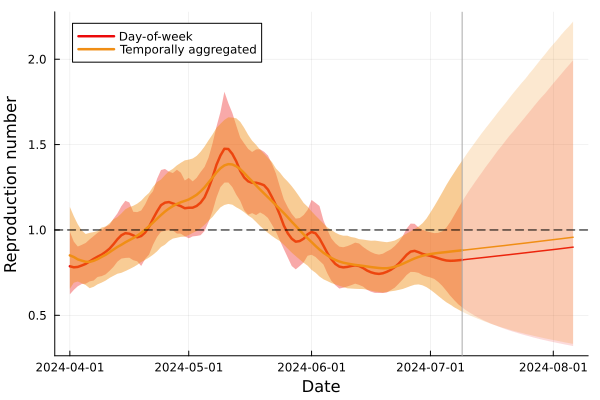

In [2]:
# Plot reproduction number estimates
pltR = plot(xlabel="Date", ylabel="Reproduction number")

plot!(Y.date[1:100], mR_dow[1:100], ribbon = (mR_dow[1:100]-lR_dow[1:100], uR_dow[1:100]-mR_dow[1:100]), color="#eb0a0a", fillalpha=0.35, linewidth=2.5, label="Day-of-week")
plot!(Y.date[1:100], mR_agg[1:100], ribbon = (mR_agg[1:100]-lR_agg[1:100], uR_agg[1:100]-mR_agg[1:100]), color="#f08e15", fillalpha=0.45, linewidth=2.5, label="Temporally aggregated")

plot!(Y.date[100:128], mR_dow[100:end], ribbon = (mR_dow[100:end]-lR_dow[100:end], uR_dow[100:end]-mR_dow[100:end]), color="#eb0a0a", fillalpha=0.15, linewidth=1.5, label=false)
plot!(Y.date[100:128], mR_agg[100:end], ribbon = (mR_agg[100:end]-lR_agg[100:end], uR_agg[100:end]-mR_agg[100:end]), color="#f08e15", fillalpha=0.2, linewidth=1.5, label=false)

hline!([1] , label=false, color=:black, line=:dash)
vline!([Y.date[100]], label=false, color=:darkgray)


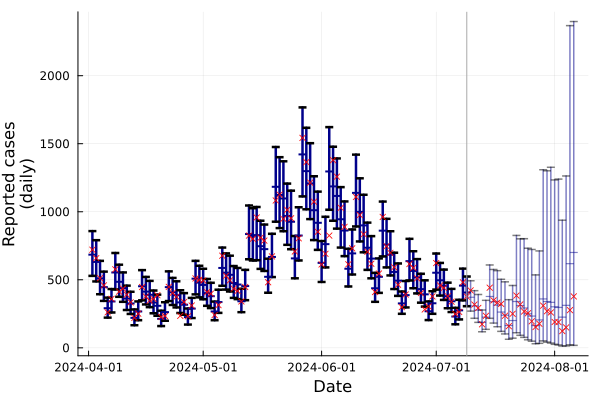

Day-of-week model coverage: 0.9696969696969697
Day-of-week model predictive coverage: 1.0


In [3]:
# Plot observed cases (day-of-week model)
pltC_dow = plot(xlabel="Date", ylabel="Reported cases\n(daily)")
scatter!(Y.date[2:100], mC_dow[2:100], errorbar=(mC_dow[2:100]-lC_dow[2:100], uC_dow[2:100]-mC_dow[2:100]),
    label=false, marker=:hline, color=:darkblue, lc=:darkblue, linewidth=2.5, markerstrokewidth=2.5)
scatter!(Y.date[101:128], mC_dow[101:end], errorbar=(mC_dow[101:end]-lC_dow[101:end], uC_dow[101:end]-mC_dow[101:end]),
    label=false, marker=:hline, color=:darkblue, lc=:darkblue, linewidth=1.5, markerstrokewidth=1.5, alpha=0.5)
scatter!(Y.date[2:128], Y.Ct[2:128], color=:red, marker=:x, label=false, markerstrokewidth=1, markersize=3)
vline!([Y.date[100]], label=false, color=:darkgray)
display(pltC_dow)

coverage = mean((Y.Ct[2:100] .>= lC_dow[2:100]) .& (Y.Ct[2:100] .<= uC_dow[2:100]))
predictive_coverage = mean((Y.Ct[101:128] .>= lC_dow[101:end]) .& (Y.Ct[101:128] .<= uC_dow[101:end]))
println("Day-of-week model coverage: ", coverage)
println("Day-of-week model predictive coverage: ", predictive_coverage)

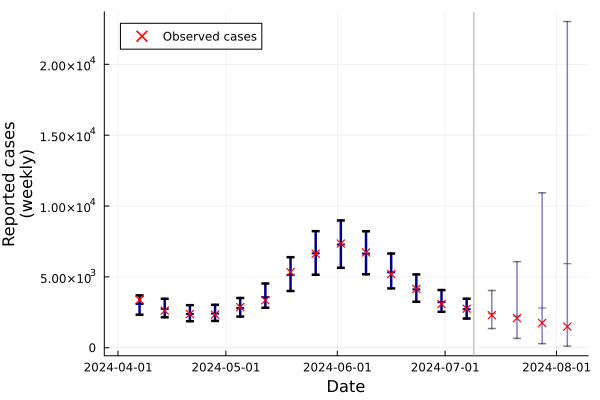

In [4]:
# Plot observed cases (temporally aggregated model)
weekly_cases = Y.WeeklyCases[1:128]
mC_agg[isnan.(weekly_cases)] .= NaN
lC_agg[isnan.(weekly_cases)] .= NaN
uC_agg[isnan.(weekly_cases)] .= NaN

pltC_agg = plot(xlabel="Date", ylabel="Reported cases\n(weekly)")
scatter!(Y.date[1:100], mC_agg[1:100], errorbar=(mC_agg[1:100]-lC_agg[1:100], uC_agg[1:100]-mC_agg[1:100]),
    label=false, marker=:hline, color=:darkblue, lc=:darkblue, linewidth=2.5, markerstrokewidth=2.5)
scatter!(Y.date[101:128], mC_agg[101:end], errorbar=(mC_agg[101:end]-lC_agg[101:end], uC_agg[101:end]-mC_agg[101:end]),
    label=false, marker=:hline, color=:darkblue, lc=:darkblue, linewidth=1.5, markerstrokewidth=1.5, alpha=0.5)
scatter!(Y.date[1:128], Y.WeeklyCases[1:128], color=:red, marker=:x, label="Observed cases", markerstrokewidth=1.5, markersize=4)
vline!([Y.date[100]], label=false, color=:darkgray)
display(pltC_agg)

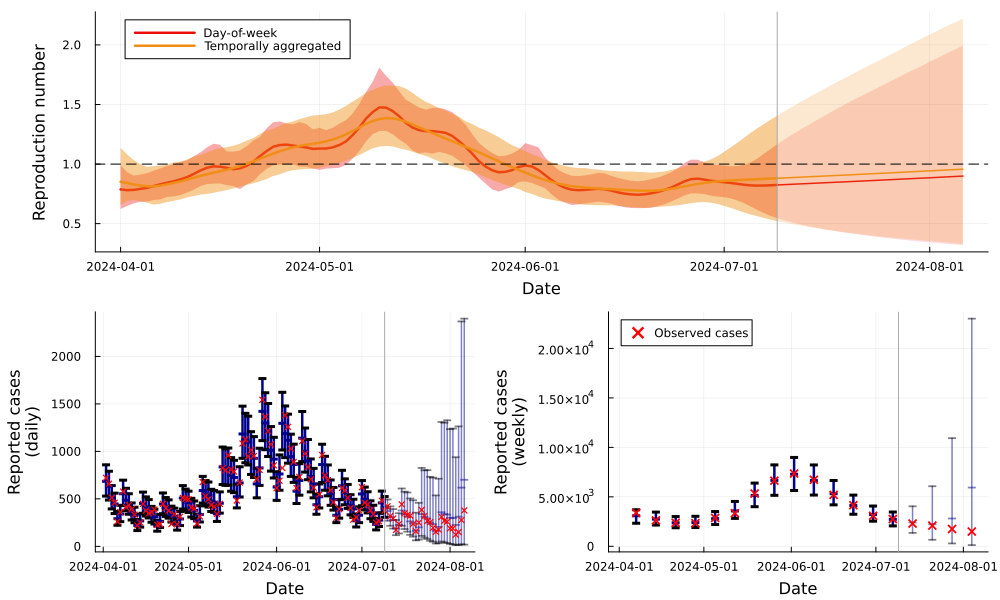

In [5]:
# Plot them all together
pltLower = plot(pltC_dow, pltC_agg, layout=(1,2))
plt = plot(pltR, pltLower, layout=(2,1), size=(1000, 600), left_margin=5mm, bottom_margin=2mm)
png("figures/temporalmodels.png")
display(plt)

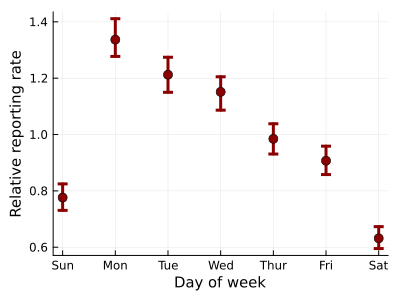

In [6]:
# Also plot daily reporting rates
θlong = resizeParams(θdow)
day_of_week_samples = zeros(size(θlong, 1), 7)
day_of_week_samples[:,1:6] = θlong[:,3:8]
day_of_week_samples[:,7] = 7 .- sum(θlong[:,3:8], dims=2)
m = mean(day_of_week_samples, dims=1)[1:end]
l = [quantile(day_of_week_samples[:,ii], 0.025) for ii = 1:7]
u = [quantile(day_of_week_samples[:,ii], 0.975) for ii = 1:7]

day_of_week_label = ["Sun", "Mon", "Tue", "Wed", "Thur", "Fri", "Sat"]

plt_dow = scatter(day_of_week_label, m, errorbar=(m-l, u-m),
    xlabel="Day of week", ylabel="Relative reporting rate", legend=false,
    linewidth=3, color=:darkred, lc=:darkred, markercolor=:darkred, markersize=5,
    yguidefont=font(10), xguidefont=font(10), size=(400,300))
png("figures/dayofweekeffect.png")
display(plt_dow)

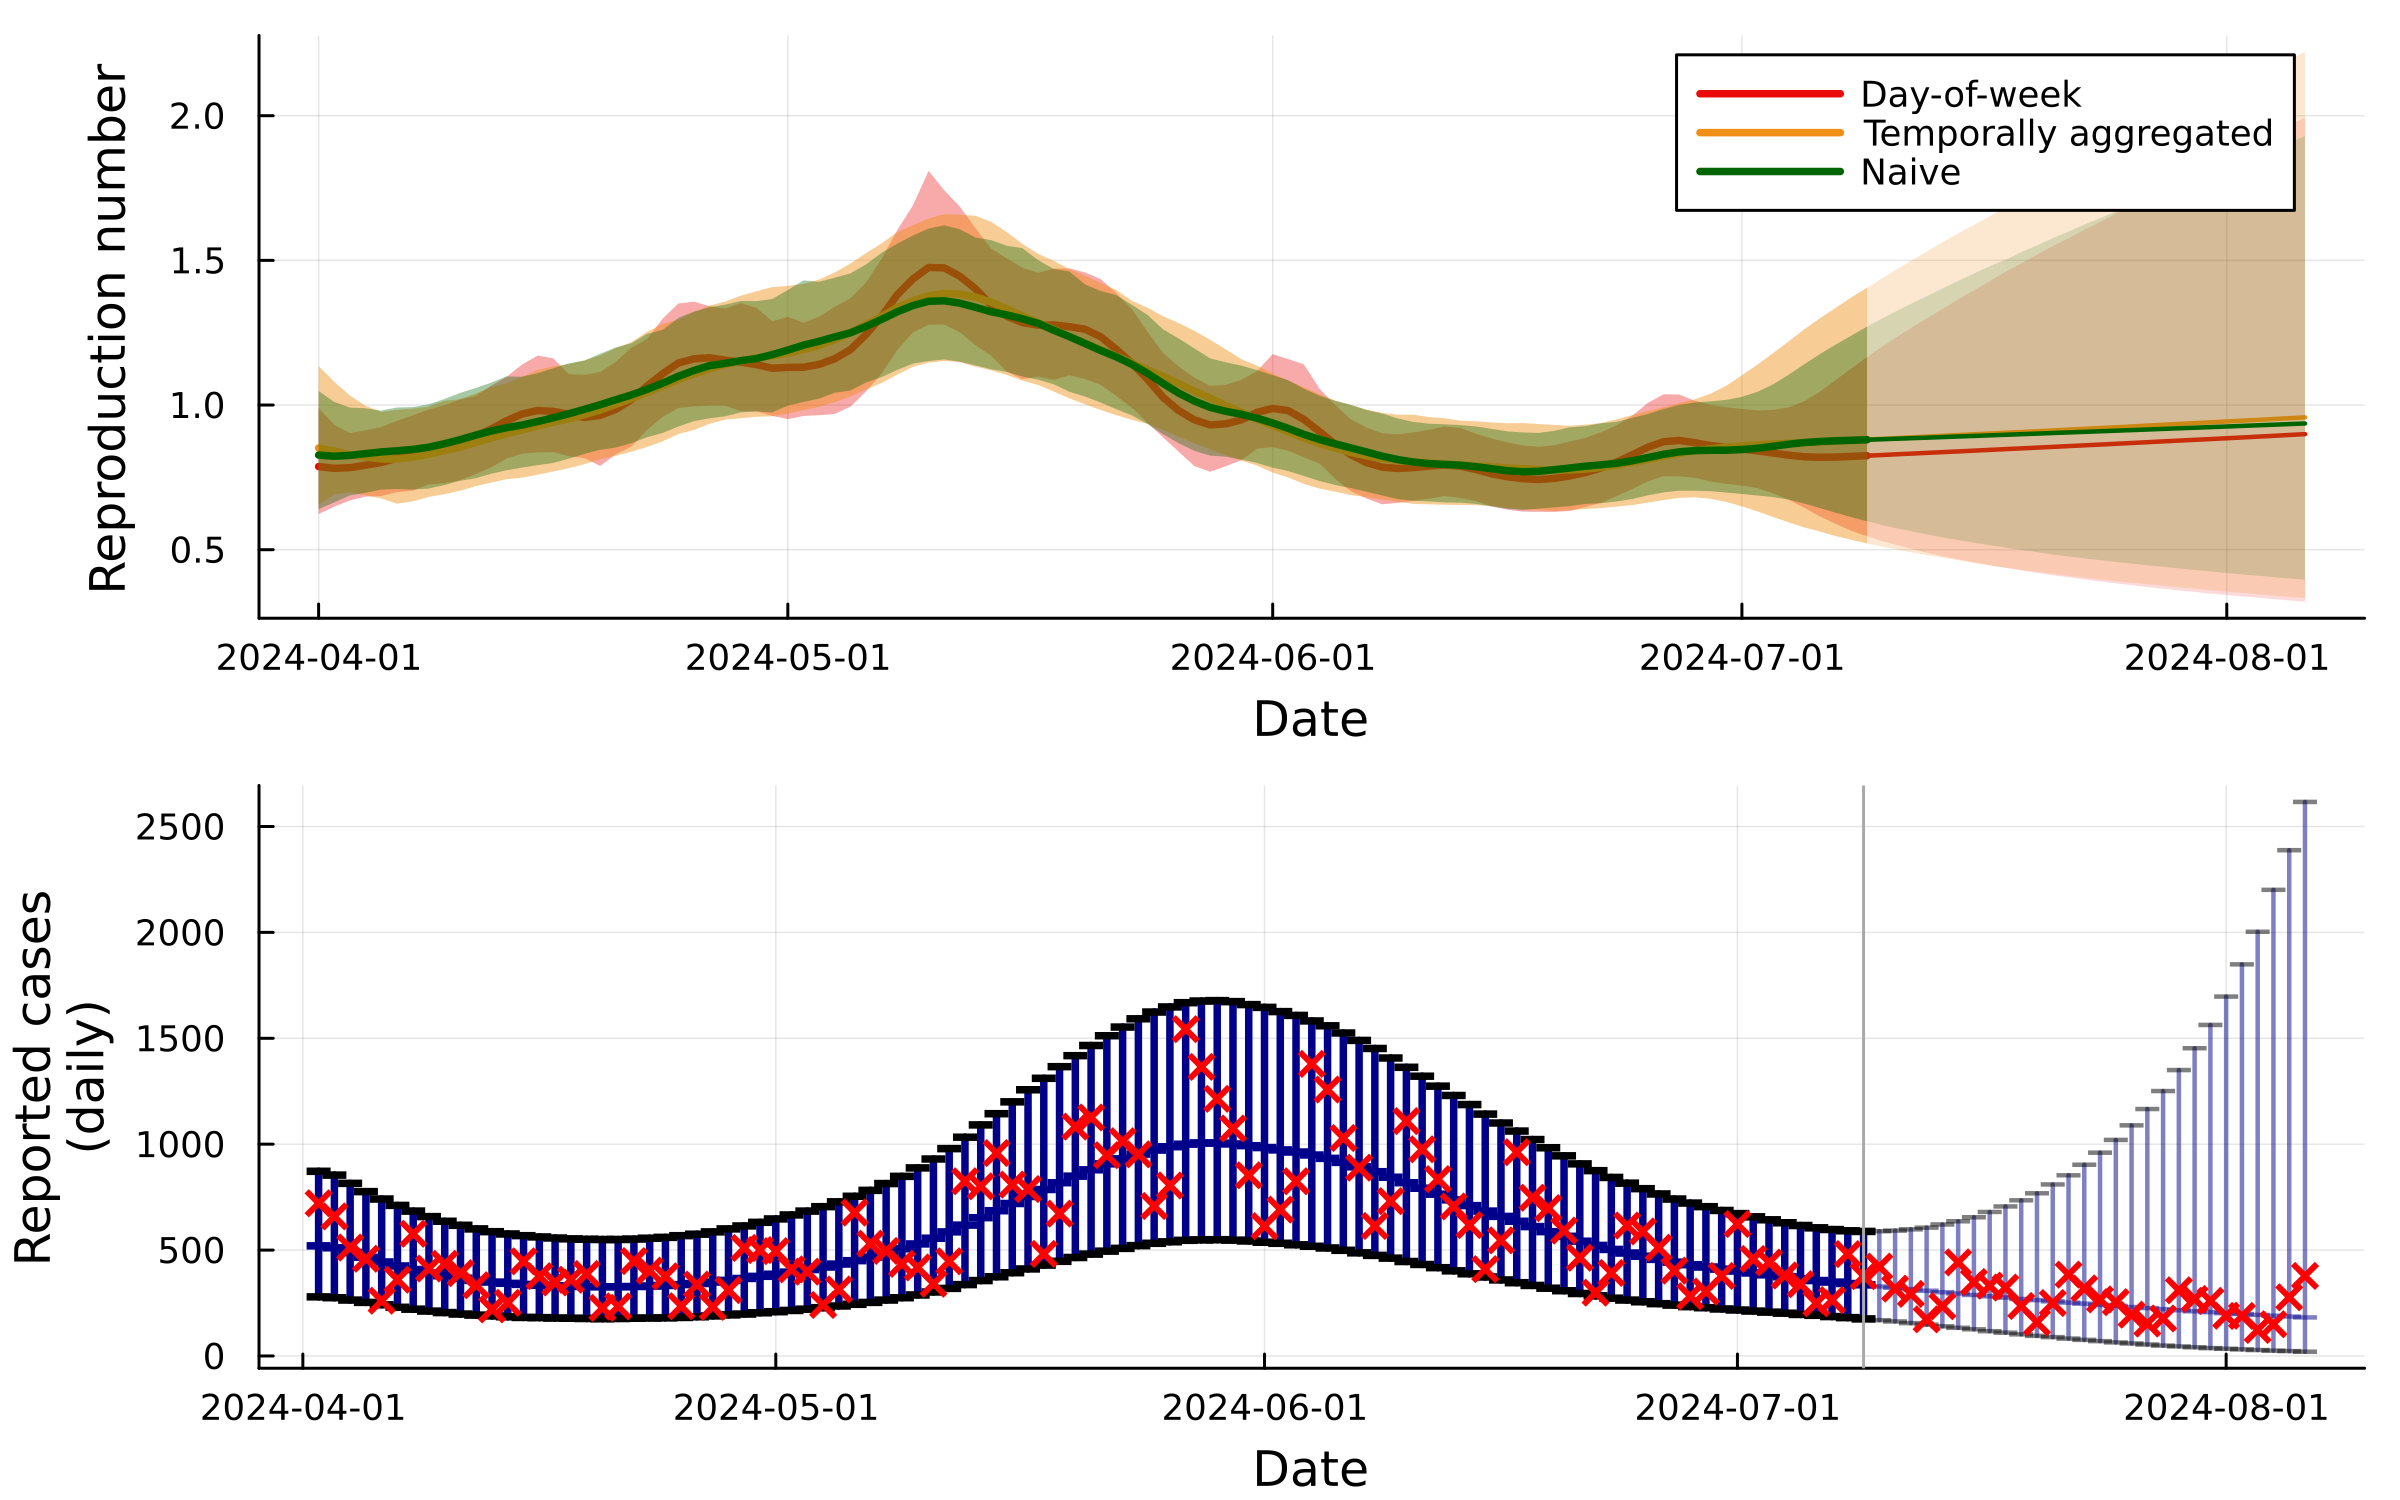

Naive model coverage: 1.0
Naive model predictive coverage: 1.0
Naive model MSE: 26568.491221520166
Naive model predictive MSE: 2.865422382120706e6
Naive model CRPS: 87.8672397979798
Naive model predictive CRPS: 61.36184514285714

Day-of-week model coverage: 0.9696969696969697
Day-of-week model predictive coverage: 1.0
Day-of-week model MSE: 4906.243706071105
Day-of-week model predictive MSE: 11194.879199025714
Day-of-week model CRPS: 33.48856690909091
Day-of-week model predictive CRPS: 45.481494285714284


Chains MCMC chain (400×2×3 Array{Float64, 3}):

Iterations        = 1:1:400
Number of chains  = 3
Samples per chain = 400
parameters        = param_1, param_2

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

     param_1    0.0649    0.0191     0.0006    0.0015   162.2780    1.0120
     param_2    0.0731    0.0099     0.0003    0.0008   110.0407    1.0154

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     param_1    0.0385    0.0520    0.0623    0.0734    0.1159
     param_2    0.0527    0.0670    0.0729    0.0815    0.0919


In [7]:
# Comparisons with the naive model
pltR_nai = plot(xlabel="Date", ylabel="Reproduction number")

plot!(Y.date[1:100], mR_dow[1:100], ribbon = (mR_dow[1:100]-lR_dow[1:100], uR_dow[1:100]-mR_dow[1:100]), color="#eb0a0a", fillalpha=0.35, linewidth=2.5, label="Day-of-week")
plot!(Y.date[100:128], mR_dow[100:end], ribbon = (mR_dow[100:end]-lR_dow[100:end], uR_dow[100:end]-mR_dow[100:end]), color="#eb0a0a", fillalpha=0.15, linewidth=1.5, label=false)

plot!(Y.date[1:100], mR_agg[1:100], ribbon = (mR_agg[1:100]-lR_agg[1:100], uR_agg[1:100]-mR_agg[1:100]), color="#f08e15", fillalpha=0.45, linewidth=2.5, label="Temporally aggregated")
plot!(Y.date[100:128], mR_agg[100:end], ribbon = (mR_agg[100:end]-lR_agg[100:end], uR_agg[100:end]-mR_agg[100:end]), color="#f08e15", fillalpha=0.2, linewidth=1.5, label=false)

plot!(Y.date[1:100], mR_nai[1:100], ribbon = (mR_nai[1:100]-lR_nai[1:100], uR_nai[1:100]-mR_nai[1:100]), color=:darkgreen, fillalpha=0.35, linewidth=2.5, label="Naive")
plot!(Y.date[100:128], mR_nai[100:end], ribbon = (mR_nai[100:end]-lR_nai[100:end], uR_nai[100:end]-mR_nai[100:end]), color=:darkgreen, fillalpha=0.15, linewidth=1.5, label=false)


# Plot observed cases (naive model)
pltC_nai = plot(xlabel="Date", ylabel="Reported cases\n(daily)")
scatter!(Y.date[2:100], medC_nai[2:100], errorbar=(medC_nai[2:100]-lC_nai[2:100], uC_nai[2:100]-medC_nai[2:100]),
    label=false, marker=:hline, color=:darkblue, lc=:darkblue, linewidth=2.5, markerstrokewidth=2.5)
scatter!(Y.date[101:128], medC_nai[101:end], errorbar=(medC_nai[101:end]-lC_nai[101:end], uC_nai[101:end]-medC_nai[101:end]),
    label=false, marker=:hline, color=:darkblue, lc=:darkblue, linewidth=1.5, markerstrokewidth=1.5, alpha=0.5)
scatter!(Y.date[2:128], Y.Ct[2:128], color=:red, marker=:x, label=false, markerstrokewidth=2, markersize=4)
vline!([Y.date[100]], label=false, color=:darkgray)

plt = plot(pltR_nai, pltC_nai, layout=(2,1), size=(800, 500), left_margin=3mm, dpi=300)
png("figures/suppl_naivemodel.png")
display(plt)

include("../src/ScoringRules.jl")

coverage = mean((Y.Ct[2:100] .>= lC_nai[2:100]) .& (Y.Ct[2:100] .<= uC_nai[2:100]))
predictive_coverage = mean((Y.Ct[101:128] .>= lC_nai[101:end]) .& (Y.Ct[101:128] .<= uC_nai[101:end]))
println("Naive model coverage: ", coverage)
println("Naive model predictive coverage: ", predictive_coverage)

mse = mean((Y.Ct[2:100] - mC_nai[2:100]).^2)
predictive_mse = mean((Y.Ct[101:128] - mC_nai[101:end]).^2)
println("Naive model MSE: ", mse)
println("Naive model predictive MSE: ", predictive_mse)

crps = CRPS(Xnai[1:500,2:100,3], Y.Ct[2:100])
predictive_crps = CRPS(Xnai[1:500,101:128,3], Y.Ct[101:128])
println("Naive model CRPS: ", crps)
println("Naive model predictive CRPS: ", predictive_crps)

println()

coverage = mean((Y.Ct[2:100] .>= lC_dow[2:100]) .& (Y.Ct[2:100] .<= uC_dow[2:100]))
predictive_coverage = mean((Y.Ct[101:128] .>= lC_dow[101:end]) .& (Y.Ct[101:128] .<= uC_dow[101:end]))
println("Day-of-week model coverage: ", coverage)
println("Day-of-week model predictive coverage: ", predictive_coverage)

mse = mean((Y.Ct[2:100] - mC_dow[2:100]).^2)
predictive_mse = mean((Y.Ct[101:128] - mC_dow[101:end]).^2)
println("Day-of-week model MSE: ", mse)
println("Day-of-week model predictive MSE: ", predictive_mse)

crps = CRPS(Xdow[1:500,2:100,3], Y.Ct[2:100])
predictive_crps = CRPS(Xdow[1:500,101:128,3], Y.Ct[101:128])
println("Day-of-week model CRPS: ", crps)
println("Day-of-week model predictive CRPS: ", predictive_crps)

using MCMCChains
display(Chains(θnai))